# Initialization

In [1]:
# to install the packages needed for this notebook please uncomment the following two lines and run this cell
# using Pkg
# Pkg.add(["WAV","FFTW","Plots","Plotly", "LinearAlgebra", "StatsBase"])

In [2]:
# load needed packages
using WAV, FFTW, Plots, LinearAlgebra, StatsBase
# audio playing with the wavplay function is not support for Windows and it does not work in the binder environment 

# uncommnet this for audio playing functionality on Linux
# include("./assets/wavplay-pulse.jl")

# uncommnet this for audio playing functionality on macOS
include("./assets/wavplay-audioqueue.jl")

# set up default parameters for plots 
gr(size=(800,400), lw = 2, lc = :black)

# enable plotly backend if you want interactive plots
# plotly(size=(800,300), lw = 2, lc = :black)

Plots.GRBackend()

# Creating Simple Waves

In [3]:
function sin_wave(frequency,amplitude,fs,τ)
    #=
    frequency: cycles per second
    amplitude: multiplier to the sin
    fs:        samples per second
    τ:         total time duration of the wave
    =#
    # the semicolon (;) in Julia is not obligatory but prevents value emmision aka printing
    xs = range(0, τ, length=τ*fs);
    amplitude * sin.(2pi * frequency * xs) # last value to be emmited is returned automatically
end

sin_wave (generic function with 1 method)

The above function creates a sin wave with a given frequency, amplitude, samples per second, and the total time duration of the wave. See the gif below for a graphical explanation.

![Alt Text](./assets/Sine_curve_drawing_animation.gif)

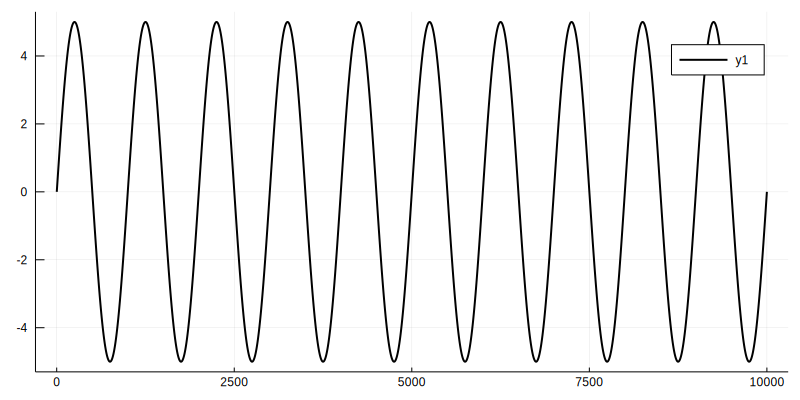

In [4]:
# The Let syntax allows creating a local environment in which all values inside it are local.
w = let frequency = 1, amplitude = 5, fs = 1000, τ = 10
    sin_wave(frequency,amplitude,fs,τ)
end
plot(w)

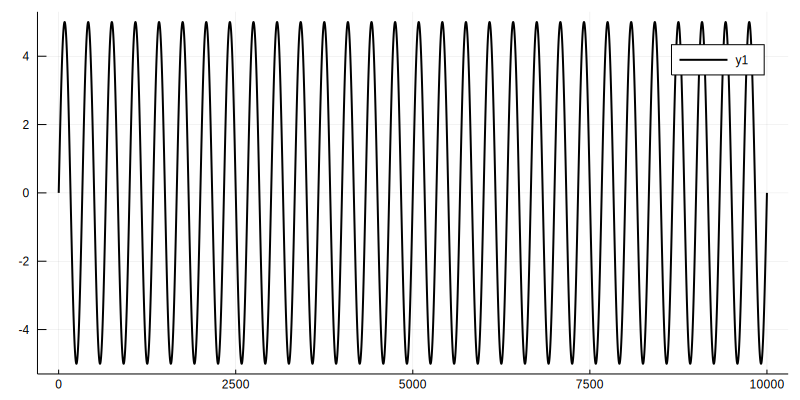

In [5]:
# let's try to increase the frequency
w = let frequency = 3, amplitude = 5, fs = 1000, τ = 10
    sin_wave(frequency,amplitude,fs,τ)
end
plot(w)

In [6]:
#= 
The function cos_wave creates a wave by adding three different cosine waves with amplitudes 1,2,3 and 
frequencies 10,30,80 respectively. The @. is called broadcast macro and it allows us to broadcast / vectorize 
an expression or function. In this case it is used because t is an array.
=#
cos_wave(t) = @. 1cos(2pi * 10t) + 2cos(2pi * 30t) + 3cos(2pi * 80t)

cos_wave (generic function with 1 method)

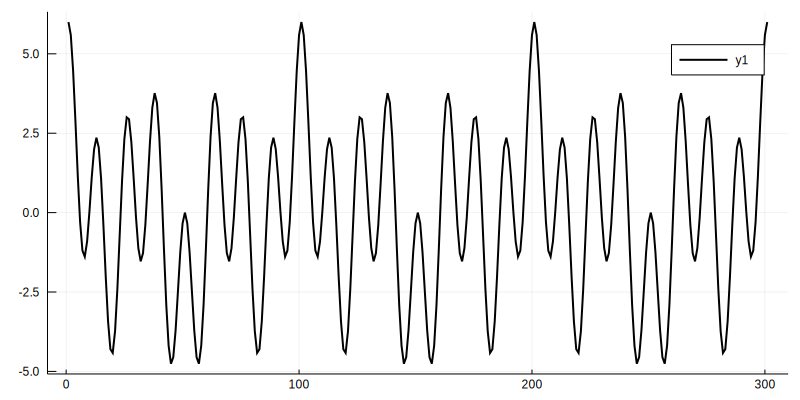

In [7]:
#= In Julia ranges are created with the colon (:) operator, 
the collect function takes a range and returns the collected values =#
let fs = 1000, T = 1/fs, τ = 0.3, t = collect(range(0, τ, step=T))
    plot(cos_wave(t))
end

# Why you should be interested in the fourier transform?

The following code uses the Fast Fourier Transform (fft) from the package FFTW and the cos_wave function which we defined earlier. (An explanation of the following code is presented after the plot)

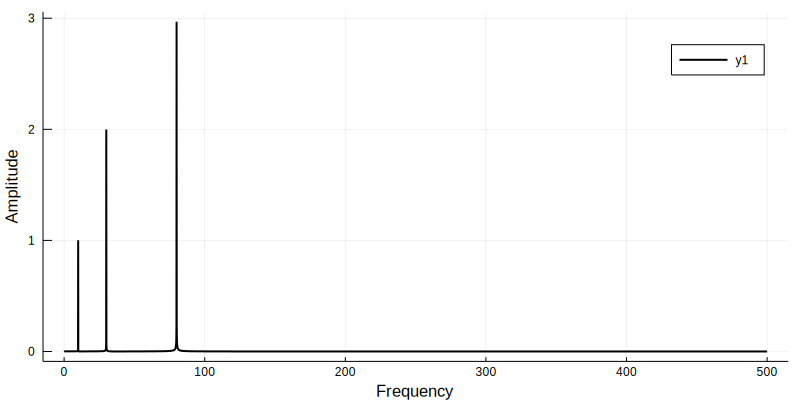

In [8]:
let fs = 1000, τ = 10, t = range(0, τ, length = τ * fs)
    y = cos_wave(t)
    y_fft = fft(y) .|> abs
    y_fft = y_fft[1:Int64(length(y) / 2) + 1] / length(y)
    y_fft[2:end-1] *= 2
    freqs = range(0, fs / 2, step = fs / length(y))
    plot(freqs, y_fft, xlabel = "Frequency", ylabel = "Amplitude")
end

Using the Fourier Transform we were able to determine the frequencies and amplitudes from the signal. This is amazing! This means that even if we do not have any knowledge about how the original signal was created,  we are still able to determine its component's properties. See the gif below for an   enlightening graphical representation of how a Fourier Transform is applied on a signal $f$.  
  
Let's analyze the code that produced the above plot. 
* Firstly, we create a range of values t and pass it to cos_wave which returns a cosine wave,
* Then, we apply the Fast Fourier Transform and take the absolute values of the results. The absolute value of a complex number is defined as its euclidean distance from the point (0,0). The bigger the complex's distance from the center is, the better it matches the wave that $g(x)$ is multiplied with.  
* Following that, we keep only the first half of the Fourier Transform components and multiply their values by 2. This is done because by nature, the Fourier Transform is symmetric and its line of symmetry is in the center of the signal (length/2). Additionally we normalize the values by dividing them with the length of the signal. This is needed because, as you will learn in the following cells, the Fourier Transform is essentially a sum of multiplications (or a dot product between two vectors).  
* Last but not least, we create the x-axis values which contain all the possible frequencies that the given signal can have. From the Nyquist theorem a signal with 1000 samples per second can represent frequencies up to fs/2 = 500.

![](https://upload.wikimedia.org/wikipedia/commons/7/72/Fourier_transform_time_and_frequency_domains_%28small%29.gif)

# The Fourier Transform Equation


The equation of the Fourier Transform: $$\Large \hat{g}(t) = \int_{-\infty}^{\infty} \! g(t) * e^{-2\pi * i * f * t} \, \mathrm{d}t $$

At first look the above equation looks very daunting but let's take a moment to understand why it is the way it is. We will start by explaining each of its components: 
* $g(t)$ is a wave function exactly like waves we created earlier with the _wave_ function.  
* $\hat{g}(t)$ is the Fourier Transform of the wave function, it is convention to represent it using a _hat_ symbol.  
* $e^{2\pi*i}$, this is perhaps the strangest part of the equation, let's break it down. First of all, it is derived from Euler's identity $e^{i*x} = cos(x) + i*sin(x)$. Using this identity each point on a unit circle (a circle with radius = 1 and center = (0,0)) can be expressed in a single complex $e^{i*x}$ number instead of the coordinates $(x,y) = (cos(x), sin(x))$. When $x = 2\pi$ the identity describes the full length of the circle's circumference.  
* $t$ symbolizes time and it is needed in the expression $e^{2\pi*i}$ in order to add the concept of a wave's evolution through time. Otherwise, all the data points would be in the same point in time.   
* $f$ is the frequency of rotation, a higher frequency means more rotations per minute and a lower frequency means fewer rotations. A more intuitive way to think of this is as a multiplier to the time component. If $f$ is small then time increases slower and thus $e^{2\pi*i}$ takes longer to complete a full rotation. The opposite happens when you multiply time with a larger number like 2 or 3 etc.   
* $-$ the minus sine is added because often when dealing with rotation it is convention to think about rotating in the clockwise direction. If this was not added, rotation using Euler's identity would be counter clockwise because of the way it is defined.

Considering all the above components the following is a brief description of how the Fourier Transform works:  
The Fourier Transform tries to match sine and cosine waves of increasing frequency $f$ with the given function $g(t)$. For each frequency the sum of the series of multiplications is calculated and is represented by a complex number. Frequencies that match better the original signal $g(t)$ have larger real values which corresponds to that frequency's amplitude.

# The Discrete Fourier Transform

In computers infinity can often cause problems because well... you cannot compute infinite things. But, to the rescue comes our friend Discretization.  
$$\Large \hat{g}(t) = \sum_{n = 0}^{N-1} \! g(n) * e^{-2\pi * i * f * n / N} $$  

From the fundamental theorem of calculus an integral can be thought of as a sum of the surfaces of rectangles covering the area under a curve. To better understand the above sentence I urge you to watch [this wonderful graphical explanation.](https://www.youtube.com/watch?v=rfG8ce4nNh0)

The above sentence is important because with that in mind we can replace the integral in the continuous version of the Fourier Transform with a series sum. By doing so we can get a bit more insight into how the Fourier Transform is calculated. Specifically what I want you to notice for now is the following: 
* in each step of the sum if the components $\large g(n)$ and $\large  e^{-2\pi * i * f * n / N}$ are close in value then the product will be a positive number and specifically $g^2(n)$ in the case where they are equal,
* if their values are opposite from one another then their product will be negative and
* in any other case their value will be in-between the first and the second case.  

Armed with the weapon of discretization let's implement our own discrete Fourier Transform function. The below cell implements the discrete Fourier Transform in two ways, using a loop and a vectorized approach. Then we will compare out results with the built-in fft methods and do a time comparison.

In [9]:
function custom_dft_loop(g)
    N = length(g)
    ft = Array{Complex{Float64}, 1}(undef, N) # creating an 1d array of size N filled with undefined values
    for f in 0:N-1 # for every value in this range
        ft[f+1] = 0
        for n in 1:N
            ft[f+1] += g[n] * exp(-2pi * im * f * n / N)
        end
    end
    ft # remember, last value is returned automatically
end

function custom_dft_dot(g)
    N = length(g)
    n = 1:N
    [dot(g, exp.(-2pi * im * f * n / N)) for f in 0:N-1]
end

custom_dft_dot (generic function with 1 method)

In [10]:
# let's validate our custom dft functions againts the builtin Fourier Transform
let fs = 1000, T = 1/fs, τ = 3, t = collect(range(0, τ, step=T))
    w = cos_wave(t)
    [fft(w) custom_dft_loop(w) custom_dft_dot(w)]
end

3001×3 Array{Complex{Float64},2}:
     6.0+0.0im             6.0+0.0im             6.0+0.0im
 6.00141+0.00628257im  6.00141-0.00628257im  6.00141-0.00628257im
 6.00564+0.012574im    6.00564-0.012574im    6.00564-0.012574im
 6.01275+0.0188834im   6.01275-0.0188834im   6.01275-0.0188834im
 6.02281+0.02522im     6.02281-0.02522im     6.02281-0.02522im
 6.03593+0.0315938im   6.03593-0.0315938im   6.03593-0.0315938im
 6.05228+0.0380154im   6.05228-0.0380154im   6.05228-0.0380154im
 6.07204+0.0444963im   6.07204-0.0444963im   6.07204-0.0444963im
 6.09547+0.0510495im   6.09547-0.0510495im   6.09547-0.0510495im
 6.12288+0.0576892im   6.12288-0.0576892im   6.12288-0.0576892im
 6.15466+0.0644323im   6.15466-0.0644323im   6.15466-0.0644323im
 6.19128+0.0712978im   6.19128-0.0712978im   6.19128-0.0712978im
 6.23336+0.0783087im   6.23336-0.0783087im   6.23336-0.0783087im
        ⋮                                    
 6.23336-0.0783087im   6.23336+0.0783087im   6.23336+0.0783087im
 6.19128-0.0712978

In [11]:
# time comparison between our custom dft functions and the built-in one
let fs = 1000, T = 1/fs, τ = 5, t = collect(range(0, τ, step=T))
    w = cos_wave(t);
    @time fft(w);
    @time custom_dft_loop(w);
    @time custom_dft_dot(w);
end

  0.003479 seconds (53 allocations: 159.391 KiB)
  0.727499 seconds (2 allocations: 78.266 KiB)
  0.856740 seconds (10.01 k allocations: 382.309 MiB, 8.85% gc time)


5001-element Array{Complex{Float64},1}:
  6.000000000030617 + 0.0im
 6.0005060267669235 - 0.0037694757360055135im
  6.002026076638115 - 0.007540864212785226im
   6.00456608121218 - 0.011316090585362685im
  6.008136004381796 - 0.015097105103771885im
  6.012749960956882 - 0.01888589603636385im
  6.018426386226983 - 0.022684503487455796im
  6.025188260983355 - 0.02649503384757391im
  6.033063396749504 - 0.030319675609885462im
   6.04208478824931 - 0.0341607164409079im
  6.052291041928828 - 0.03802056226653239im
   6.06372689121003 - 0.04190175838846878im
 6.0764438122666276 - 0.04580701341841339im
                    ⋮
  6.076443812286404 + 0.045807013437748054im
 6.0637268912303846 + 0.04190175842725923im
 6.0522910419401645 + 0.03802056225514772im
  6.042084788238242 + 0.03416071667181015im
 6.0330633967588945 + 0.030319675592817442im
  6.025188260981634 + 0.0264950338700163im
     6.018426386213 + 0.022684503521810343im
  6.012749960896696 + 0.018885896052859966im
  6.008136004231346 +

##  Insight from our custom implementation

Even at the best case, our implementation is 2 orders of magnitude slower than the built-in fast Fourier Transform. I encourage you to experiment with the above time comparison, you will find that as you increase the end time $\tau$ and the signal gets larger, the time difference between our custom function and the built-in one will grow very fast. This is because our implementation is of the order $O(n^2)$ while the optimized built-in fft is $O(nlogn)$.  
But how can the fast Fourier Transform be so much faster? The answer lies in symmetry. As we mentioned earlier the Fourier Transform is symmetric, by taking advantage of this fast it is possible to create a very efficient Fourier Transform algorithm such as the Cooley-Tukey FFT algorithm. For a more detailed explanation I urge you to read [this post.](https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/)

# Application: Lossy compression using FFT

The Fourier Transform enjoys application in almost all signal processing pipelines. It is used most often when one needs to apply numerous frequency filters on a signal. For example humans can hear frequencies up to 22KHz and this means that frequencies higher than that are not useful in an ordinary audio file. This task can be performed by applying a low pass filter on the Fourier Transform of the signal and then using the inverse Fourier Transform to construct the new signal.  
The application of a low pass filter is one of the many application of the Fourier Transform. In this notebook we will see how we to compress an audio file using the first N components of the Fourier Transform of a signal.

We will create a function named fft_compress which takes a signal, the samples per second and an float n. Then it applies the Fourier Transform, keeps the first n% of components and uses them to recreate the original signal.  
Later we compare the amplitude-frequency graph of the original signal versus the compressed and we use the wavplay from the package "WAV" in order to hear the impact that compressing has in the original signal.

In [12]:
function fft_compress(y, fs, n)
    y_fft = fft(y)
    n_fft = y_fft[1:floor(Int64, n * length(y_fft))] # keep the first n% of components
    # apply zero padding at the end of n_fft, this is needed because we want the recreated signal to have the same legth as y
    append!(n_fft, zeros(ComplexF64, length(y_fft) - length(n_fft)))
    iy_fft = ifft(n_fft) .|> real |> hcat # keep the real part of the coplex numbers and transform the 1d array to a signle column 2d array.
end

fft_compress (generic function with 1 method)

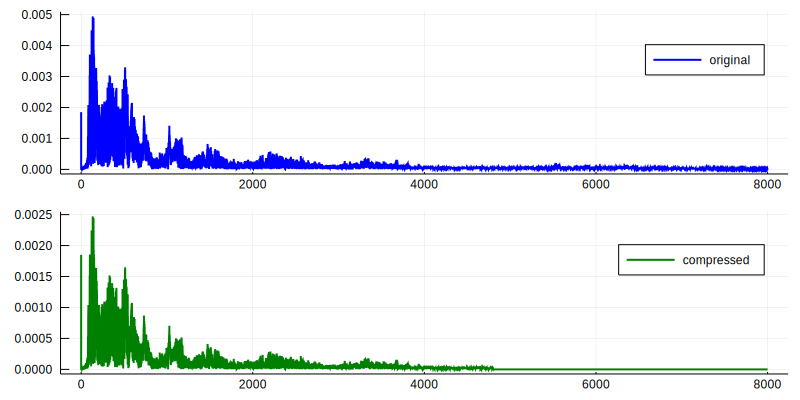

In [13]:
y, fs, _, _ = wavread("./assets/joe.wav") # read the audio file


# the following code is identical to the one we saw earlier for producing the amplitude-frequency plot of the cosine wave.
y_fft = fft(y) .|> abs # apply fft and keep the absolute
y_fft = y_fft[1:floor(Int64, length(y) / 2) + 1] / length(y) # keep only the first half
y_fft[2:end-1] *= 2
freqs = range(0, fs / 2, step = fs / length(y)) # create the x axis with the possible frequencies

cy_fft = fft_compress(y, fs, 0.3) |> fft .|> abs
cy_fft = cy_fft[1:floor(Int64, length(cy_fft) / 2) + 1] / length(cy_fft)
cy_fft[2:end-1] *= 2

plot(freqs, [y_fft, cy_fft], layout = (2, 1), lab = ["original" "compressed"], lc = [:blue :green])

In [14]:
cy = fft_compress(y, fs, 0.3)
plot([y, cy], layout = (2, 1), lab = ["original" "compressed"], lc = [:blue :green])

In [16]:
# CAUTION! this code will play the signal
wavplay(y, fs)
wavplay(fft_compress(y, fs, 0.3) * 2, fs) # the 2 increases the amplitude of the signal and makes it louder

I encourage you to experiment with the compression function, try out different n values and listen how that affects the audio quality. You will find that as you decrease n the "color" of the sound is lost. This is because higher frequencies contain the detail of the signal.